In [14]:
import sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

sys.path.append('./../')  # Needed for importing from simulation_utils.py
from simulation_utils import *


In [15]:
def run_numpy_simulation(gate_fidelity, epr_channel_fidelity):
    # Define target state as the Bell state |phi_{00}>
    TARGET_STATE = bell_state()

    # Define EPL circuit (Alice and Bob each apply CNOT: control=first qubit, target=second qubit)
    # NOTE: we apply depolarizing channels only to gates that appear in the original BBPSSW protocol,
    # and not to additional SWAP gates

    epl_circuit = QuantumCircuit([
        Gate(kron([I(), SWAP(), I()])),     # Swap to get 1A, 2A, 1B, 2B

        Gate(kron([CNOT(), I(), I()])),        # Apply CNOT(1A, 2A)
        DepolarizingChannel(gate_fidelity, 4, [0, 1]),

        Gate(kron([I(), I(), CNOT()])),        # Apply  CNOT(1B, 2B)
        DepolarizingChannel(gate_fidelity, 4, [2, 3]),

        Gate(kron([I(), SWAP(), I()])),     # Swap back to get 1A, 1B, 2A, 2B

        # Measure 2A and 2B
        POVM(num_qubits=4, meas_qubits=[2, 3], partial_trace=True),
    ])

    # Create two Werner states
    epr_1 = epr_2 = werner_state(epr_channel_fidelity)

    # Combined system: |1A, 1B, 2A, 2B⟩
    rho = kron([epr_1, epr_2])

    # Apply BBPSSW circuit
    probs, rho_outs = epl_circuit(rho)

    # Compute fidelity wrt. the Bell state phi_00
    fidels = np.array([fidelity(dm, TARGET_STATE) for dm in rho_outs])

    # Compute probability of success and average fidelity **given** success
    prob_succ = np.sum(probs[[3]])
    fidel_succ = np.dot(fidels[[3]], probs[[3]]) / prob_succ

    return prob_succ, fidel_succ

In [16]:
GRID_SIZE = 51
numpy_sim_results = []

for gate_fidelity in np.linspace(0, 1, GRID_SIZE):
    for epr_channel_fidelity in np.linspace(0, 1, GRID_SIZE):
        prob_succ, fidel_succ = run_numpy_simulation(gate_fidelity, epr_channel_fidelity)
        numpy_sim_results.append([gate_fidelity, epr_channel_fidelity, prob_succ, fidel_succ])

numpy_sim_results = np.array(numpy_sim_results)

cols = ['Gate fidelity', 'EPR channel fidelity', 'P_Succ', 'F_succ']
numpy_sim_results = pd.DataFrame(numpy_sim_results, columns=cols)

numpy_sim_results

,Gate fidelity,EPR channel fidelity,P_Succ,F_succ
0,0.0,0.00,0.2500,0.250000
1,0.0,0.02,0.2500,0.250000
2,0.0,0.04,0.2500,0.250000
3,0.0,0.06,0.2500,0.250000
4,0.0,0.08,0.2500,0.250000
...,...,...,...,...
2596,1.0,0.92,0.4616,0.957539
2597,1.0,0.94,0.4709,0.968624
2598,1.0,0.96,0.4804,0.979392
2599,1.0,0.98,0.4901,0.989849


### Extracting results from NetQASM

In [17]:
def _get_p_succ_and_f_succ(df: pd.DataFrame):
    """Computes the probability of success and fidelity given success."""
    return [
        (df['M_Alice'] & df['M_Bob']).mean(),
        df.query('M_Alice == 1 and M_Bob == 1')['Fidelity'].mean(),
    ]


def _series_to_numpy(s: pd.Series):
    """Converts a `pandas.Series` containing lists to a numpy array by depth-1 list flattening."""
    # NOTE: this function can only be applied to the specific series used here
    return np.array([np.concatenate(row) for row in s.items()])


def get_p_succ_and_f_succ(data: pd.DataFrame):
    """
    Computes the probability of success and fidelity given success,
    grouped by gate and EPR channel fidelities, in the given `DataFrame`.
    """
    # Group data by gate and channel fidelity
    result = data.groupby(['Gate fidelity', 'EPR channel fidelity'])

    result = result.apply(_get_p_succ_and_f_succ, include_groups=False)
    result = _series_to_numpy(result)

    cols = ['Gate fidelity', 'EPR channel fidelity', 'P_succ', 'F_succ']
    result = pd.DataFrame(result, columns=cols)

    return result

# Read simulation results
netqasm_sim_results = pd.read_csv('./out_epl.csv')
netqasm_sim_results = get_p_succ_and_f_succ(netqasm_sim_results)

netqasm_sim_results

,Gate fidelity,EPR channel fidelity,P_succ,F_succ
0,0.0,0.0,0.23,0.260870
1,0.0,0.2,0.26,0.192308
2,0.0,0.4,0.31,0.187792
3,0.0,0.6,0.23,0.152174
4,0.0,0.8,0.20,0.525000
5,0.0,1.0,0.16,0.125000
6,0.2,0.0,0.33,0.196970
7,0.2,0.2,0.26,0.384615
8,0.2,0.4,0.20,0.316363
9,0.2,0.6,0.24,0.260417


### Plotting

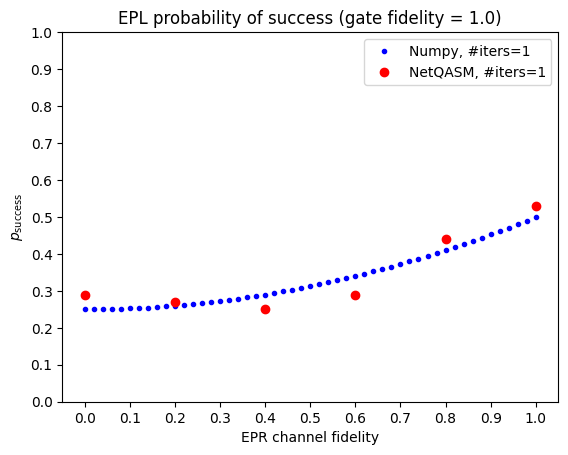

In [18]:
ps = np.linspace(0, 1, 101)
plt.plot(
    numpy_sim_results.query('`Gate fidelity` == 1.0')['EPR channel fidelity'],
    numpy_sim_results.query('`Gate fidelity` == 1.0')['P_Succ'],
    '.b', label='Numpy, #iters=1',
)
plt.plot(
    netqasm_sim_results.query('`Gate fidelity` == 1.0')['EPR channel fidelity'],
    netqasm_sim_results.query('`Gate fidelity` == 1.0')['P_succ'],
    'ro', label='NetQASM, #iters=1'
)
plt.title('EPL probability of success (gate fidelity = 1.0)')
plt.xlabel('EPR channel fidelity')
plt.ylabel(r'$p_\text{success}$')
ticks = np.arange(11)/10
plt.xticks(ticks, ticks)
plt.yticks(ticks, ticks)
plt.legend()
plt.show()

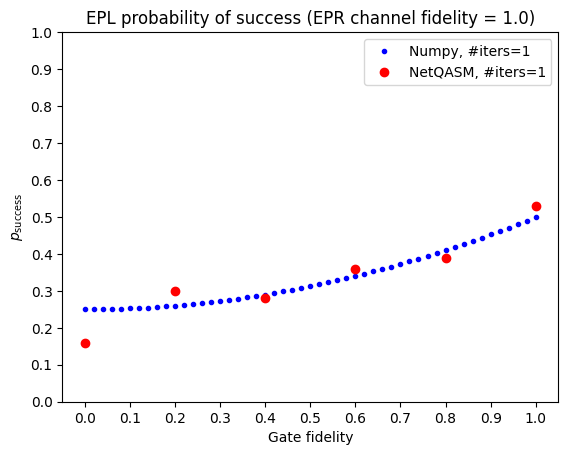

In [19]:
ps = np.linspace(0, 1, 101)
plt.plot(
    numpy_sim_results.query('`EPR channel fidelity` == 1.0')['Gate fidelity'],
    numpy_sim_results.query('`EPR channel fidelity` == 1.0')['P_Succ'],
    '.b', label='Numpy, #iters=1',
)
plt.plot(
    netqasm_sim_results.query('`EPR channel fidelity` == 1.0')['Gate fidelity'],
    netqasm_sim_results.query('`EPR channel fidelity` == 1.0')['P_succ'],
    'ro', label='NetQASM, #iters=1'
)
plt.title('EPL probability of success (EPR channel fidelity = 1.0)')
plt.xlabel('Gate fidelity')
plt.ylabel(r'$p_\text{success}$')
ticks = np.arange(11)/10
plt.xticks(ticks, ticks)
plt.yticks(ticks, ticks)
plt.legend()
plt.show()

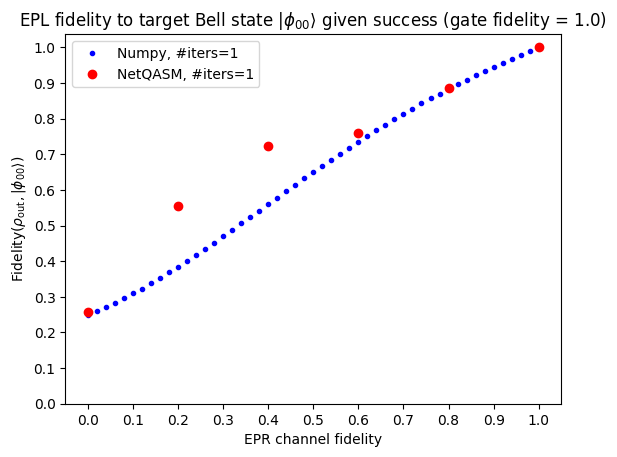

In [20]:
ps = np.linspace(0, 1, 101)



plt.plot(
    numpy_sim_results.query('`Gate fidelity` == 1.0')['EPR channel fidelity'],
    numpy_sim_results.query('`Gate fidelity` == 1.0')['F_succ'],
    '.b', label='Numpy, #iters=1',
)

plt.plot(
    netqasm_sim_results.query('`Gate fidelity` == 1.0')['EPR channel fidelity'],
    netqasm_sim_results.query('`Gate fidelity` == 1.0')['F_succ'],
    'ro', label='NetQASM, #iters=1'
)

plt.title(r'EPL fidelity to target Bell state $\vert\phi_{00}\rangle$ given success (gate fidelity = 1.0)')
plt.xlabel('EPR channel fidelity')
plt.ylabel(r'$\text{Fidelity}(\rho_\text{out}, \vert\phi_{00}\rangle)$')
ticks = np.arange(11)/10
plt.xticks(ticks, ticks)
plt.yticks(ticks, ticks)
plt.legend()
plt.show()

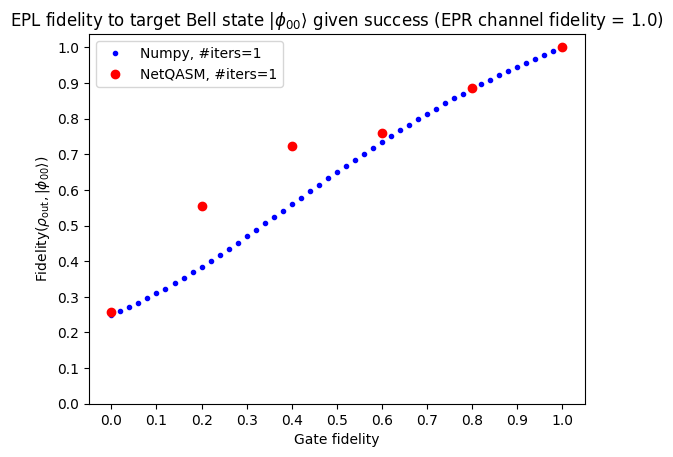

In [21]:
ps = np.linspace(0, 1, 101)

plt.plot(
    numpy_sim_results.query('`Gate fidelity` == 1.0')['EPR channel fidelity'],
    numpy_sim_results.query('`Gate fidelity` == 1.0')['F_succ'],
    '.b', label='Numpy, #iters=1',
)

plt.plot(
    netqasm_sim_results.query('`Gate fidelity` == 1.0')['EPR channel fidelity'],
    netqasm_sim_results.query('`Gate fidelity` == 1.0')['F_succ'],
    'ro', label='NetQASM, #iters=1'
)

plt.title(r'EPL fidelity to target Bell state $\vert\phi_{00}\rangle$ given success (EPR channel fidelity = 1.0)')
plt.xlabel('Gate fidelity')
plt.ylabel(r'$\text{Fidelity}(\rho_\text{out}, \vert\phi_{00}\rangle)$')
ticks = np.arange(11)/10
plt.xticks(ticks, ticks)
plt.yticks(ticks, ticks)
plt.legend()
plt.show()